In [1]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm

### Run Commot

In [2]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [3]:
# adata.X = adata.layers['imputed_count']
adata.X = adata.layers['normalized_count']

In [4]:
adata.X.max()

8.8678228953803

In [5]:
df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='human', 
    signaling_type=None
)

df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  
df_ligrec['name'] = df_ligrec['ligand'] + '-' + df_ligrec['receptor']
len(df_ligrec['name'].unique())

1938

In [6]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.network import expand_paired_interactions

expanded = expand_paired_interactions(df_ligrec)
genes = set(expanded.ligand) | set(expanded.receptor)
genes = list(genes)

expanded

,ligand,receptor,pathway,signaling,name
0,TGFB1,TGFBR1,TGFb,Secreted Signaling,TGFB1-TGFBR1_TGFBR2
0,TGFB1,TGFBR2,TGFb,Secreted Signaling,TGFB1-TGFBR1_TGFBR2
1,TGFB2,TGFBR1,TGFb,Secreted Signaling,TGFB2-TGFBR1_TGFBR2
1,TGFB2,TGFBR2,TGFb,Secreted Signaling,TGFB2-TGFBR1_TGFBR2
2,TGFB3,TGFBR1,TGFb,Secreted Signaling,TGFB3-TGFBR1_TGFBR2
...,...,...,...,...,...
1936,ITGA9,VCAM1,VCAM,Cell-Cell Contact,ITGA9_ITGB1-VCAM1
1936,ITGB1,VCAM1,VCAM,Cell-Cell Contact,ITGA9_ITGB1-VCAM1
1937,ITGA4,VCAM1,VCAM,Cell-Cell Contact,ITGA4_ITGB7-VCAM1
1937,ITGB7,VCAM1,VCAM,Cell-Cell Contact,ITGA4_ITGB7-VCAM1


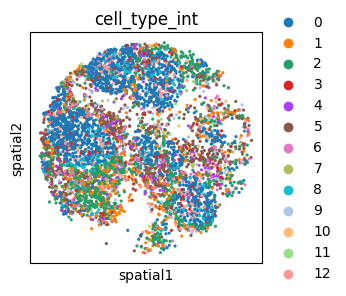

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.embedding(adata, 'spatial', color='cell_type_int')

In [8]:
expanded = expanded[expanded.ligand.isin(adata.var_names) & expanded.receptor.isin(adata.var_names)]

In [9]:
%%time

ct.tl.spatial_communication(adata,
    database_name='user_database', 
    # df_ligrec=df_ligrec, 
    df_ligrec=expanded, 
    dis_thr=350, 
    # heteromeric=True
    heteromeric=False
)

CPU times: user 54min 34s, sys: 10min 26s, total: 1h 5min 1s
Wall time: 1h 5min 12s


In [10]:
adata.write_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')

In [11]:
expanded['rename'] = expanded['ligand'] + '-' + expanded['receptor']

In [12]:
from tqdm import tqdm
import commot as ct

for name in tqdm(expanded['rename'].unique()):

    ct.tl.cluster_communication(
        adata, 
        database_name='user_database', 
        pathway_name=name, 
        clustering='cell_type',
        random_seed=12, 
        n_permutations=100
    )

100%|██████████| 958/958 [40:11<00:00,  2.52s/it]


In [13]:
adata.write_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')

In [14]:
from collections import defaultdict
data_dict = defaultdict(dict)

for name in expanded['rename']:
    data_dict[name]['communication_matrix'] = adata.uns[
        f'commot_cluster-cell_type-user_database-{name}']['communication_matrix']
    data_dict[name]['communication_pvalue'] = adata.uns[
        f'commot_cluster-cell_type-user_database-{name}']['communication_pvalue']

import pickle
with open('/Users/koush/Desktop/training_data/tonsil_communication.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [15]:
# check outputs

import pickle
with open('/Users/koush/Desktop/training_data/tonsil_communication.pkl', 'rb') as f:
    info = pickle.load(f)

len(info.keys())

958

In [19]:
def get_sig_interactions(value_matrix, p_matrix, pval=0.3):
    p_matrix = np.where(p_matrix < pval, 1, 0)
    return value_matrix * p_matrix

interactions = {}
for lig, rec in tqdm(zip(expanded['ligand'], expanded['receptor'])):
    name = lig + '-' + rec

    if name in info.keys():

        value_matrix = info[name]['communication_matrix']
        p_matrix = info[name]['communication_pvalue']

        sig_matrix = get_sig_interactions(value_matrix, p_matrix)
        
        if sig_matrix.sum().sum() > 0:
            interactions[name] = sig_matrix
    
len(interactions)

1397it [00:00, 6263.53it/s]


958

### Get expanded LR masks

In [21]:
len(interactions.keys())

958

In [22]:
# create cell x gene matrix
ct_masks = {ct: adata.obs['cell_type'] == ct for ct in adata.obs['cell_type'].unique()}

df = pd.DataFrame(index=adata.obs_names, columns=genes)
df = df.fillna(0)

for name in tqdm(interactions.keys(), total=len(interactions)):
    lig, rec = name.rsplit('-', 1)
    
    tmp = interactions[name].sum(axis=1)
    for ct, val in zip(interactions[name].index, tmp):
        df.loc[ct_masks[ct], lig] += tmp[ct]
    
    tmp = interactions[name].sum(axis=0)
    for ct, val in zip(interactions[name].columns, tmp):
        df.loc[ct_masks[ct], rec] += tmp[ct]

df.shape

100%|██████████| 958/958 [00:18<00:00, 52.70it/s]


(5778, 958)

In [23]:
print('Number of LR filtered using celltype specificity:')
np.where(df > 0, 1, 0).sum().sum() / (df.shape[0] * df.shape[1])

Number of LR filtered using celltype specificity:


0.3755467611290685

In [24]:
df.to_parquet('/Users/koush/Desktop/training_data/tonsil_LRs.parquet')

In [25]:
ligands = ['IL2', 'IL7']
df[ligands].sum(axis=0)

IL2    0.000000
IL7    5.405941
dtype: float64

### Get ligand receivers mask for tissue density weighting

In [26]:
df = pd.read_parquet('/Users/koush/Desktop/training_data/tonsil_LRs.parquet')
df.head(3)

,ADORA1,HLA-DOA,CCL2,TAC4,CCL1,CHRNE,WNT8B,ADORA2B,IL13RA2,CD27,...,TSHR,PGF,CD6,MCHR1,CNTN2,NTSR1,GAS6,CHRNG,IL25,UCN3
NAME,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCTTG-1,0,0.000000,0.0,0.000201,0,0,0,0.000000,0,0.000036,...,0,0.000000,0.005608,0,0.000007,0,0.000267,0,0,0
AAACCCAAGTGGACGT-1,0,0.000133,0.0,0.000074,0,0,0,0.000000,0,0.000146,...,0,0.000000,0.000000,0,0.000006,0,0.002320,0,0,0
AAACCCACAGAAGTGC-1,0,0.000513,0.0,0.000000,0,0,0,0.000002,0,0.000048,...,0,0.000003,0.000000,0,0.000005,0,0.000204,0,0,0


In [28]:
ligand_receivers_mask = pd.DataFrame(
    index=df.index, 
    columns=np.unique(expanded.ligand)
).fillna(0)

for _, row in tqdm(expanded.iterrows(), total=len(expanded)):
    ligand = row.ligand
    receptor = row.receptor

    receivers = df[receptor].values
    ligand_receivers_mask.loc[:, ligand] += receivers

ligand_receivers_mask.head(3)

100%|██████████| 1397/1397 [00:00<00:00, 3778.87it/s]


,ADGRE5,AGRN,ALCAM,ANGPT1,ANGPT2,ANGPTL1,ANGPTL2,ANGPTL3,ANGPTL4,ANGPTL7,...,WNT10A,WNT10B,WNT16,WNT2B,WNT3,WNT4,WNT5A,WNT5B,WNT6,WNT7A
NAME,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCTTG-1,0.000649,0.000328,0.005608,0.000000,0.002069,0.002611,0.002077,0.000581,0.002650,0.000008,...,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.000417,0.000417,0.002734,0.002734
AAACCCAAGTGGACGT-1,0.000275,0.000607,0.000000,0.000015,0.001769,0.001790,0.001778,0.001234,0.007357,0.000025,...,0.008917,0.008917,0.008917,0.008917,0.008917,0.008917,0.002929,0.002920,0.008917,0.008917
AAACCCACAGAAGTGC-1,0.000111,0.000399,0.000000,0.000001,0.002865,0.002919,0.002883,0.000901,0.003848,0.000019,...,0.002493,0.002493,0.002493,0.002493,0.002493,0.002493,0.000654,0.000635,0.002493,0.002493


In [30]:
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_type_int_colors', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-TGFB1-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB1-TGFBR2', 'commot_cluster-cell_type-user_database-TGFB2-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB2-TGFBR2', 'commot_cluster-cell_type-user_database-TGFB3-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB3-TGFBR2', 'commot_cluster-cell_type-user_database-BMP2-BMPR1A', 'commot_cluster-cell_type-user_database-BMP2-BMPR2', 'commot_cluster-cell_type-user_database-BMP2-BMPR1B', 'commot_cluster-cell_type-user_database-GDF7-BMPR1A', 'commot_cluster-cell_type-user_database-GDF7-BMPR2', 'commot_cluster-cell_type-user_database-GDF7-BMPR1B', 'commot_cluster-cell_type-user_database-BMP6-BMPR2', 'commot_cluster-cell_type-user_database-BMP6-BMPR1A', 'commot_cluster-cell_type-user_database-BMP6-BMPR1B'

In [31]:
from spaceoracle.models.parallel_estimators import *

cell_threshes = pd.read_parquet(
    '/Users/koush/Desktop/training_data/tonsil_LRs.parquet')
adata.uns['cell_thresholds'] = cell_threshes
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_type_int_colors', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-TGFB1-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB1-TGFBR2', 'commot_cluster-cell_type-user_database-TGFB2-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB2-TGFBR2', 'commot_cluster-cell_type-user_database-TGFB3-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB3-TGFBR2', 'commot_cluster-cell_type-user_database-BMP2-BMPR1A', 'commot_cluster-cell_type-user_database-BMP2-BMPR2', 'commot_cluster-cell_type-user_database-BMP2-BMPR1B', 'commot_cluster-cell_type-user_database-GDF7-BMPR1A', 'commot_cluster-cell_type-user_database-GDF7-BMPR2', 'commot_cluster-cell_type-user_database-GDF7-BMPR1B', 'commot_cluster-cell_type-user_database-BMP6-BMPR2', 'commot_cluster-cell_type-user_database-BMP6-BMPR1A', 'commot_cluster-cell_type-user_database-BMP6-BMPR1B'

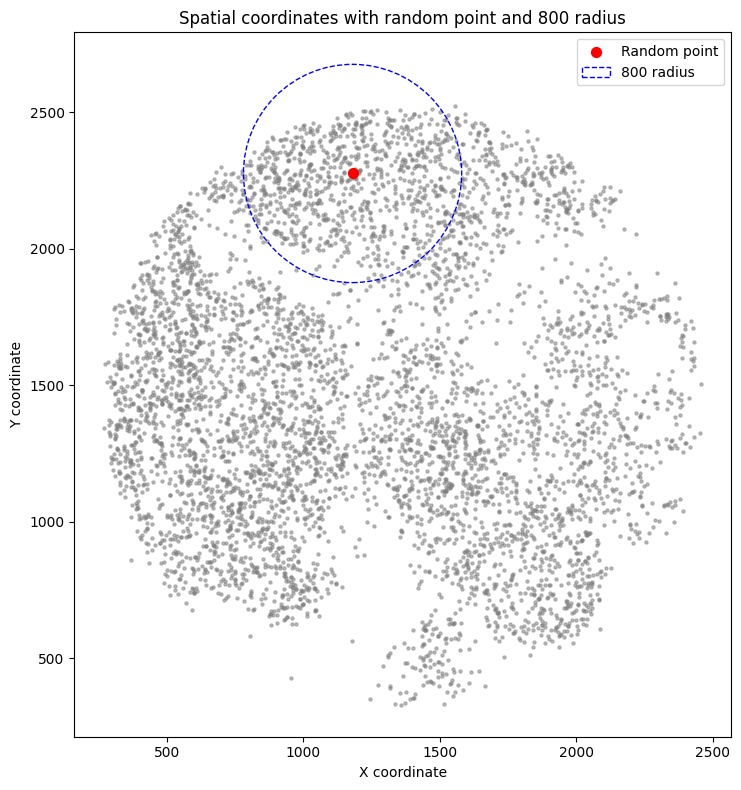

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get spatial coordinates
coords = adata.obsm['spatial']

# Randomly select a point
random_idx = random.randint(0, len(coords) - 1)
random_point = coords[random_idx]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all points
ax.scatter(coords[:, 0], coords[:, 1], s=5, alpha=0.5, color='gray')

# Plot the randomly selected point
ax.scatter(random_point[0], random_point[1], s=50, color='red', label='Random point')

# Draw a circle with radius 800 around the random point
circle = plt.Circle((random_point[0], random_point[1]), 400, fill=False, color='blue', linestyle='--', label='800 radius')
ax.add_patch(circle)

# Set labels and title
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Spatial coordinates with random point and 800 radius')
ax.legend()

# Set equal aspect ratio
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [47]:
adata = init_received_ligands(
    adata, 
    radius=400, 
    contact_distance=50, 
    cell_threshes=cell_threshes
)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_type_int_colors', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-TGFB1-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB1-TGFBR2', 'commot_cluster-cell_type-user_database-TGFB2-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB2-TGFBR2', 'commot_cluster-cell_type-user_database-TGFB3-TGFBR1', 'commot_cluster-cell_type-user_database-TGFB3-TGFBR2', 'commot_cluster-cell_type-user_database-BMP2-BMPR1A', 'commot_cluster-cell_type-user_database-BMP2-BMPR2', 'commot_cluster-cell_type-user_database-BMP2-BMPR1B', 'commot_cluster-cell_type-user_database-GDF7-BMPR1A', 'commot_cluster-cell_type-user_database-GDF7-BMPR2', 'commot_cluster-cell_type-user_database-GDF7-BMPR1B', 'commot_cluster-cell_type-user_database-BMP6-BMPR2', 'commot_cluster-cell_type-user_database-BMP6-BMPR1A', 'commot_cluster-cell_type-user_database-BMP6-BMPR1B'

In [48]:
keys = list(adata.obsm.keys())
for key in keys:
    if 'commot' in key:
        del adata.obsm[key]
        
keys = list(adata.uns.keys())
for key in keys:
    if 'commot' in key:
        del adata.uns[key]
        
keys = list(adata.obsp.keys())
for key in keys:
    if 'commot' in key:
        del adata.obsp[key]

In [49]:
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_type_int_colors', 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [50]:
adata.write_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')